In [17]:
# acf and pacf plots of total power usage
from numpy import split
from numpy import array
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from math import sqrt
from numpy import split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


In [18]:
import scipy
scipy.__version__

    

'1.2.1'

In [6]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test


In [7]:
# convert windows of weekly multivariate data into a series of total power
def to_series(data):
    # extract just the total power from each week
    series = [week[:, 0] for week in data]
    # flatten into a single series
    series = array(series).flatten()
    return series

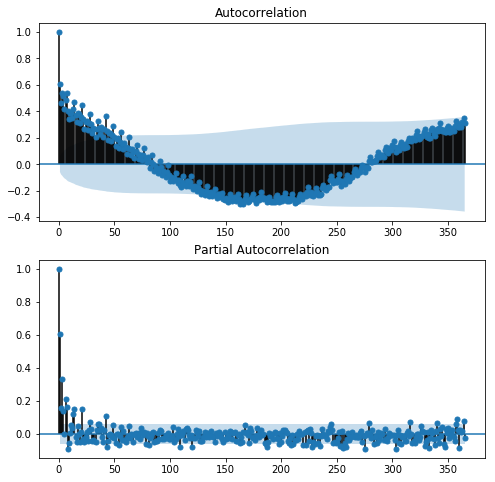

In [15]:
# load the new file
dataset = read_csv('smart meter dataset\household_power_consumption\household_power_consumption_Naive_Forecast_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# convert training data into a series
series = to_series(train)

#pyplot.subplots_adjust(left=None, bottom=4, right=None, top=15, wspace=None, hspace=None)
# plots
pyplot.figure(figsize=(8, 8))
lags = 365
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
pyplot.show()

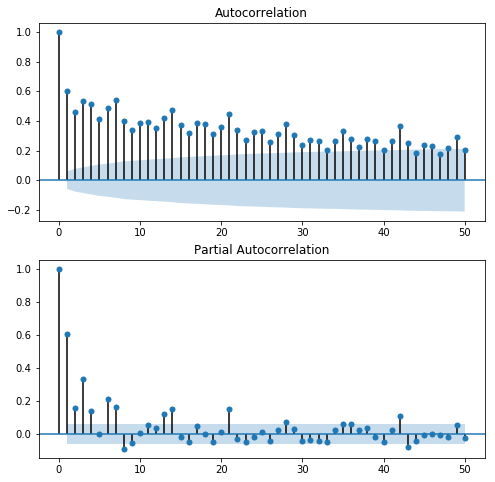

In [16]:
# plots
pyplot.figure(figsize=(8, 8))
lags = 50
# acf
axis = pyplot.subplot(2, 1, 1)
plot_acf(series, ax=axis, lags=lags)
# pacf
axis = pyplot.subplot(2, 1, 2)
plot_pacf(series, ax=axis, lags=lags)
# show plot
pyplot.show()

In [20]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

In [21]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

In [22]:
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [23]:
# arima forecast
def arima_forecast(history):
    # convert history into a univariate series
    series = to_series(history)
    # define the model
    model = ARIMA(series, order=(7,0,0))
    # fit the model
    model_fit = model.fit(disp=False)
    # make forecast
    yhat = model_fit.predict(len(series), len(series)+6)
    return yhat

arima: [381.623] 393.8, 398.9, 357.0, 377.2, 393.8, 306.0, 432.2


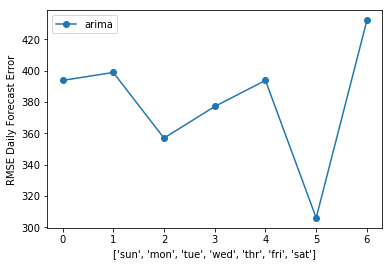

In [24]:
# load the new file
dataset = read_csv('smart meter dataset\household_power_consumption\household_power_consumption_Naive_Forecast_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the names and functions for the models we wish to evaluate
models = dict()
models['arima'] = arima_forecast
# evaluate each model
days_label = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
days = [0, 1, 2, 3, 4, 5, 6]
for name, func in models.items():
    # evaluate and get scores
    score, scores = evaluate_model(func, train, test)
    # summarize scores
    summarize_scores(name, score, scores)
    # plot scores
    pyplot.plot(days, scores, marker='o', label=name)
    pyplot.xlabel(days_label)
    pyplot.ylabel("RMSE Daily Forecast Error")
# show plot
pyplot.legend()
pyplot.show()